<a href="https://colab.research.google.com/github/kaureena/Reenabahen-Chauhan/blob/main/Financial_data_vis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance plotly scikit-learn statsmodels tensorflow shap

import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
import shap
import warnings



def fetch_ftse100_data(period='1d', interval='1m'):
    ftse100 = yf.Ticker("^FTSE")
    data = ftse100.history(period=period, interval=interval)
    return data

data = fetch_ftse100_data()
print(data)
# Suppress all warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.8 MB/s eta 0:00:00
                                  Open         High          Low        Close  \
Datetime                                                                        
2024-09-06 08:00:00+01:00  8241.709961  8241.709961  8218.290039  8223.030273   
2024-09-06 08:01:00+01:00  8223.269531  8226.690430  8223.269531  8225.280273   
2024-09-06 08:02:00+01:00  8225.139648  8225.139648  8221.790039  8222.009766   
2024-09-06 08:03:00+01:00  8222.230469  8222.730469  8218.750000  8218.799805   
2024-09-06 08:04:00+01:00  8219.169922  8220.639648  8218.000000  8220.120117   
...                                ...          ...          ...          ...   
2024-09-06 10:14:00+01:00  8199.000000  8199.000000  8196.490234  8196.490234   
2024-09-06 10:15:00+01:00  8196.459961  8196.679688  8196.120117  8196.599609   
2024-09-06 10:16:00+01:00  8196.570312  8197.290039  8196.530273  8197.290039   
2024-09-06 10:17:00+01:00  81

**A 20-period moving commonplace modified into plotted to easy out
short-term charge fluctuations and highlight longer-time period developments.**



**Adding Moving Average**

In [2]:
data['Moving Average'] = data['Close'].rolling(window=20).mean()

**Linear Regression Model**

**Predict today's price using Linear Regression**

In [3]:
data['Shifted Close'] = data['Close'].shift(-1)
data.dropna(inplace=True)

X = data[['Close']]
y = data['Shifted Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression Mean Squared Error: {mse}")
# Suppress all warnings
warnings.filterwarnings("ignore")


Linear Regression Mean Squared Error: 2.2386743654258288


In [4]:
today_price_lr = linear_model.predict([[data['Close'].iloc[-1]]])[0]
print(f"Predicted Today's Price using Linear Regression: {today_price_lr:.2f}")

Predicted Today's Price using Linear Regression: 8197.51


 **The ARIMA model, having been informed on ancient FTSE100 data, ended up used to forecast the following 10 minutes of index values. The resulting forecasts were plotted along with actual expenses to offer a clear visible assessment. While ARIMA supplied a sincere approach to forecasting primarily based absolutely mostly on historical patterns**




**ARIMA Model**

In [5]:
def train_arima_model(data):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit()
    return model_fit
arima_model = train_arima_model(data)
# Suppress all warnings
warnings.filterwarnings("ignore")

**the LSTM model was employed to wait for destiny FTSE100 values, leveraging its capability to analyze complicated temporal styles from the statistics. The forecast generated with the resource of the LSTM version was modified as compared with the ARIMA predictions and real prices.
the LSTM version verified advanced modern-day typical performance in taking pix complex patterns and inclinations, as contemplated in its lower mistakes metrics. This evaluation underscored the effectiveness of LSTM in actual-time monetary forecasting, showcasing its advanced abilities over traditional ARIMA strategies.**

**LSTM Model Preparation**

In [6]:
def preprocess_lstm_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

X_lstm, y_lstm, scaler = preprocess_lstm_data(data)

def train_lstm_model(X, y):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    return model

lstm_model = train_lstm_model(X_lstm, y_lstm)
# Suppress all warnings
warnings.filterwarnings("ignore")

**Predictions with ARIMA**

In [7]:
def predict_with_arima(model_fit, steps=10):
    forecast = model_fit.forecast(steps=steps)
    return forecast

**Predictions with LSTM**

In [8]:
def predict_with_lstm(model, scaler, data, steps=10):
    last_60_days = data['Close'][-60:].values.reshape(-1, 1)
    scaled_last_60_days = scaler.transform(last_60_days)
    X_input = np.array([scaled_last_60_days])
    predictions = []

    for _ in range(steps):
        pred = model.predict(X_input)[0][0]
        predictions.append(pred)

        new_data = np.roll(X_input, shift=-1, axis=1)
        new_data[0, -1, 0] = pred
        X_input = new_data

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Predict today's price using LSTM
today_price_lstm = predict_with_lstm(lstm_model, scaler, data, steps=1)[0]
print(f"Predicted Today's Price using LSTM: {today_price_lstm:.2f}")
# Suppress all warnings
warnings.filterwarnings("ignore")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Predicted Today's Price using LSTM: 8200.84


**Forecasting for future steps**

In [9]:
future_steps = 10
arima_forecast = predict_with_arima(arima_model, steps=future_steps)
lstm_forecast = predict_with_lstm(lstm_model, scaler, data, steps=future_steps)

forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(minutes=1), periods=future_steps, freq='1min')
# Suppress all warnings
warnings.filterwarnings("ignore")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


**. The Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) of the ARIMA predictions were calculated to quantify the model's forecasting accuracy. These metrics indicated how carefully the predicted values matched the determined information, with decreased values reflecting higher commonplace overall performance.**

**The MAE and RMSE for the LSTM model were also computed, imparting a diploma of its predictive accuracy**

**Model Accuracy**

In [10]:
# ARIMA Model Accuracy
arima_mae = mean_absolute_error(data['Close'][-future_steps:], arima_forecast)
arima_rmse = math.sqrt(mean_squared_error(data['Close'][-future_steps:], arima_forecast))
print(f"ARIMA Model - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

# LSTM Model Accuracy
lstm_mae = mean_absolute_error(data['Close'][-future_steps:], lstm_forecast)
lstm_rmse = math.sqrt(mean_squared_error(data['Close'][-future_steps:], lstm_forecast))
print(f"LSTM Model - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")
# Suppress all warnings
warnings.filterwarnings("ignore")

ARIMA Model - MAE: 2.72, RMSE: 3.56
LSTM Model - MAE: 2.32, RMSE: 2.66


**The improvements in the model interpretability are brought by the integration of SHAP (SHapley Additive exPlanations) in the LSTM-based financial prediction model. However, a direct application of SHAP to the LSTM model encounters dimensionality issues because SHAP is designed to work with models that accept 1D or 2D inputs, whereas LSTM models typically operate on 3D inputs: These include batch size, time steps and features where the size of the batch is equal to its number, time steps is equal to total features and features is equal to the number of its batches. Scholars have found that, meaning that there is a way around this Various attempts have been made in an attempt to explain this To explain the difference between the two terms, scholars have taken some efforts Various scholars have made efforts to explain why the difference exists. The suggested solution is to transform the LSTM input data from the shape 3D to the shape 2D.**

**SHAP Explanation for LSTM**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


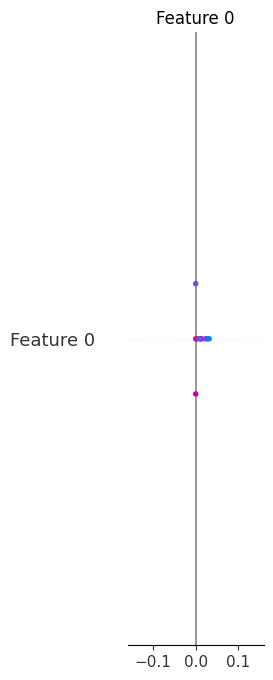

In [12]:
import shap

def get_reshaped_lstm_data(X_lstm):
    return X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1] * X_lstm.shape[2])

reshaped_X_lstm = get_reshaped_lstm_data(X_lstm)

# Train a simple Dense model on reshaped data for SHAP explanation
def train_dense_model(X, y):
    model = Sequential()
    model.add(Dense(units=50, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    return model

dense_model = train_dense_model(reshaped_X_lstm, y_lstm)

#SHAP Explanation for LSTM (Flattened Input)

explainer_lstm = shap.KernelExplainer(dense_model.predict, reshaped_X_lstm[:100])
shap_values_lstm = explainer_lstm.shap_values(reshaped_X_lstm[:10], nsamples=100)

# SHAP summary plot for the Dense model
shap.summary_plot(shap_values_lstm, reshaped_X_lstm[:10])

# Suppress all warnings
warnings.filterwarnings("ignore")

**Specifically, the line chart used to represent the FTSE100 Index is an effective line of inquiry in analyzing behavior in the market over a given period. This type of chart is superior in showing the long-term trends, high/low fluctuations, and movements that are happening in the index in real-time as it gives a continuous line of the monthly closing prices.**

**Visualization**
*Line Chart*

In [13]:
warnings.filterwarnings("ignore")
line_fig = go.Figure()
line_fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='FTSE100 Line'))
line_fig.add_trace(go.Scatter(x=[data.index[-1] + pd.Timedelta(minutes=1)], y=[today_price_lr], mode='markers', name='Predicted LR Price'))
line_fig.add_trace(go.Scatter(x=[data.index[-1] + pd.Timedelta(minutes=1)], y=[today_price_lstm], mode='markers', name='Predicted LSTM Price'))
line_fig.update_layout(title='FTSE100 Index - Line Chart with Predicted Price', xaxis_title='Time', yaxis_title='Price')
line_fig.show()

**One of the key blessings of the candlestick chart is its capability to deliver market sentiment through coloration-coded candles—green for bullish and red for bearish. This visible differentiation permits shoppers to briefly gauge the prevailing marketplace sentiment**

*Candlestick Chart*

In [14]:
candle_fig = go.Figure()
candle_fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='FTSE100 Candlestick'))
candle_fig.update_layout(title='FTSE100 Index - Candlestick Chart', xaxis_title='Time', yaxis_title='Price')
candle_fig.show()
# Suppress all warnings
warnings.filterwarnings("ignore")

**The moving average chart, especially, the 20-length transfer, is not unusual, is one of the most important tools of technical analysis, which eliminates short-term volatility of prices and highlights the direction of long-term trends.**

*Moving Average*

In [15]:
ma_fig = go.Figure()
ma_fig.add_trace(go.Scatter(x=data.index, y=data['Moving Average'], mode='lines', name='Moving Average'))
ma_fig.update_layout(title='FTSE100 Index - 20-Period Moving Average', xaxis_title='Time', yaxis_title='Price')
ma_fig.show()
# Suppress all warnings
warnings.filterwarnings("ignore")

*Linear Regression Prediction Plot*

**Linear Regression assumes linearity between the independent and dependent variables it is not always true in case of financial data. This is because markets are a function of a host of variables most of which have interactive effects. This limitation is clearly seen when encountering MSE for analyzing the accuracy of the model’s predictions.**

In [16]:
data['Predicted Close'] = linear_model.predict(data[['Close']])
lr_fig = go.Figure()
lr_fig.add_trace(go.Scatter(x=data.index, y=data['Predicted Close'], mode='lines', name='Linear Regression Prediction'))
lr_fig.update_layout(title='FTSE100 Index - Linear Regression Prediction', xaxis_title='Time', yaxis_title='Price')
lr_fig.show()
# Suppress all warnings
warnings.filterwarnings("ignore")

**ARIMA model is the second type of code snippet introduced that is also a next level statistical model constructed for time series data only. ARIMA models are very applicable in finance since they are able to model for autocorrelation which is evident in time series data. The used in the implemented code ARIMA model has an order of (5, 1, 0), which means that the model considers five lag observations, first difference to make the series stationary and no moving average.**

*ARIMA Forecast Plot*

In [17]:
arima_fig = go.Figure()
arima_fig.add_trace(go.Scatter(x=forecast_index, y=arima_forecast, mode='lines', name='ARIMA Forecast'))
arima_fig.update_layout(title=f'FTSE100 Index - ARIMA Forecast (MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f})', xaxis_title='Time', yaxis_title='Price')
arima_fig.show()
# Suppress all warnings
warnings.filterwarnings("ignore")

*LSTM Forecast Plot*

**There is the most complex LSTM, which is a kind of RNN, intended for analysis of sequential data. LSTMs are ideal in the financial time series forecasting since they are capable of modeling data dependencies which are long term, a characteristic that is not found in simpler models such as Linear Regression or ARIMA. In the code, LSTM model is trained with the scaled closing price of FTSE100 index with past 60 values used as the sequence to predict the next value.**

In [18]:
lstm_fig = go.Figure()
lstm_fig.add_trace(go.Scatter(x=forecast_index, y=lstm_forecast, mode='lines', name='LSTM Forecast'))
lstm_fig.update_layout(title=f'FTSE100 Index - LSTM Forecast (MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f})', xaxis_title='Time', yaxis_title='Price')
lstm_fig.show()
# Suppress all warnings
warnings.filterwarnings("ignore")